In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms

from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from glob import glob
import os

In [2]:
def decode_segmap(image, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [3]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [4]:
mask_preprocess = transforms.Compose([
    transforms.Resize((224,224))
])

In [5]:
class VOCSegmentation(torch.utils.data.Dataset):
    
    def __init__(self, root, year='2012', transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.year = year
        self.root = os.path.join(root,f'VOCdevkit/VOC{self.year}/')
        
        self.mask_path = os.path.join(self.root,'SegmentationClass')
        
        self.filename = glob(self.mask_path+'/*.png')
        
    def __len__(self):
        return len(self.filename)
        
    def __getitem__(self, idx):
        mask = Image.open(self.filename[idx])
        image = Image.open(self.filename[idx].replace('png','jpg').replace('SegmentationClass','JPEGImages'))
        
        if self.transform:
            image = self.transform(image)
        
        
        if self.target_transform:
            mask = self.target_transform(mask)
        
        mask = np.array(mask)
        mask = np.where(mask==255,0,mask)
        mask = torch.from_numpy(mask)
        
        return image, mask
        

In [6]:
train = VOCSegmentation('./data',transform=preprocess,target_transform=mask_preprocess)

In [7]:
trainloader = torch.utils.data.DataLoader(train,batch_size=4, num_workers=0, shuffle=True)

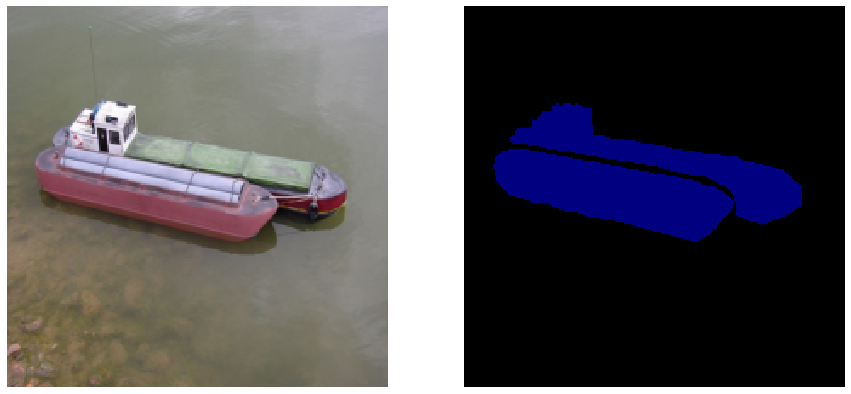

In [8]:
interest_pic = 102
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(train[interest_pic][0].permute(1,2,0).numpy())
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(decode_segmap(train[interest_pic][1]))

In [47]:
vgg = torchvision.models.vgg16(pretrained=True).features

In [56]:
class VGG(nn.Module):
    
    def __init__(self):
        super(VGG,self).__init__()
        self.model = vgg
    
    def forward(self, x):
        maxpooling_map = []
        for i, layer in enumerate(vgg):
            x = layer(x)
            if isinstance(layer,nn.MaxPool2d):
                maxpooling_map.append(x)
        return maxpooling_map

In [67]:
class UpSampling(nn.Module):
    
    def __init__(self, in_ch, out_ch):
        super(UpSampling,self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_ch,out_ch,2,stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        tmp = self.model(x)
        return tmp

In [85]:
class FCN(nn.Module):
    
    def __init__(self, n_classes):
        super(FCN,self).__init__()
        self.backbone = VGG()
        self.up1 = UpSampling(512,512)
        self.up2 = UpSampling(512,256)
        self.up3 = UpSampling(256,128)
        self.up4 = UpSampling(128,64)
        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(64,32,2,stride=2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,n_classes,1)
        )
    
    def forward(self, x):
        feature_map = self.backbone(x)
                
        score = self.up1(feature_map[-1])
        score = score + feature_map[-2]
        score = self.up2(score)
        score = score + feature_map[-3]
        score = self.up3(score)
        score = score + feature_map[-4]
        score = self.up4(score)
        score = score + feature_map[-5]
        score = self.up5(score)
        return score

In [86]:
model = FCN(20+1).cuda()

In [87]:
# test forward
with torch.no_grad():
    model.eval()
    print(model(torch.randn(4,3,224,224).cuda()).argmax(dim=1).unsqueeze(1).shape)

torch.Size([4, 1, 224, 224])


In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [89]:
EPOCHES = 10

In [90]:
model.train()
for e in range(EPOCHES):
    running_loss = 0.0
    for data in tqdm(trainloader):
        img ,label = data
        img = img.cuda()
        label = label.long().cuda()
        
        output = model(img).float()
        loss = criterion(output,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    print(f'epoch {e+1}: {running_loss/len(train)}')

  0%|                                                                                  | 1/729 [00:00<01:42,  7.09it/s]

epoch 1: 0.3792511257178342


  0%|                                                                                  | 1/729 [00:00<01:43,  7.04it/s]

epoch 2: 0.2698567280788173


  0%|                                                                                  | 1/729 [00:00<01:41,  7.19it/s]

epoch 3: 0.2560426021743549


  0%|                                                                                  | 1/729 [00:00<01:47,  6.80it/s]

epoch 4: 0.24748901217163038


  0%|                                                                                  | 1/729 [00:00<01:49,  6.67it/s]

epoch 5: 0.23923295685158863


  0%|                                                                                  | 1/729 [00:00<01:45,  6.90it/s]

epoch 6: 0.22999862973075366


  0%|                                                                                  | 1/729 [00:00<01:41,  7.19it/s]

epoch 7: 0.22297008787280212


  0%|                                                                                  | 1/729 [00:00<01:48,  6.71it/s]

epoch 8: 0.21522176608448376


  0%|                                                                                  | 1/729 [00:00<01:42,  7.09it/s]

epoch 9: 0.20888847929073534


100%|████████████████████████████████████████████████████████████████████████████████| 729/729 [01:41<00:00,  7.15it/s]

epoch 10: 0.20265582777812968


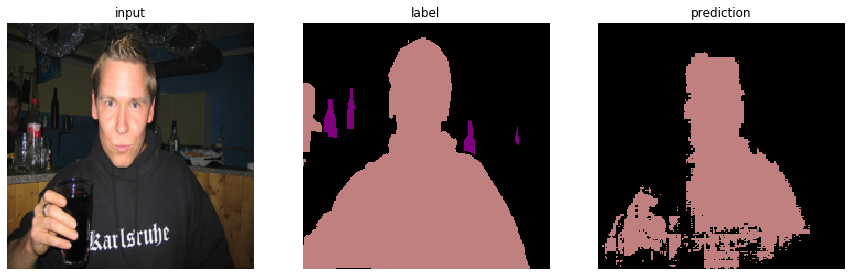

In [102]:
interest_pic = 10

model.eval()
with torch.no_grad():
    output = model(train[interest_pic][0].unsqueeze(0).cuda())
    output = output.squeeze(0).permute(1,2,0).argmax(dim=2).detach().cpu().numpy()
    
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('input')
    plt.axis('off')
    plt.imshow(train[interest_pic][0].permute(1,2,0).numpy())
    plt.subplot(1,3,2)
    plt.title('label')
    plt.axis('off')
    plt.imshow(decode_segmap(train[interest_pic][1].numpy()))
    plt.subplot(1,3,3)
    plt.title('prediction')
    plt.axis('off')
    plt.imshow(decode_segmap(output))

In [14]:
torch.onnx.export(model,torch.randn(1,3,224,224).cuda(),'a.onnx')